# UCI - Human Action Recognition - LSTM
### `import` statements

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, BatchNormalization, Dropout, Flatten, Dense
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report as cr

### Set random generator seed

In [2]:
# Set random seed
np.random.seed(42)

In [3]:
# Data directory
DATADIR = '/Users/alesandrawiecheckivergara/Desktop/PR/ICP/human+activity+recognition+using+smartphones/UCI HAR Dataset'

# Signals to load
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

activity_map = {
    0: "Walking",
    1: "Walking Upstairs",
    2: "Walking Downstairs",
    3: "Sitting",
    4: "Standing",
    5: "Laying"
}

### Utility Functions to load and process dataset

In [4]:
# Utility function to read CSV files
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Function to load signal data
def load_signals(subset):
    signals_data = []
    for signal in SIGNALS:
        filename = f'{DATADIR}/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(_read_csv(filename).to_numpy())
    return np.transpose(signals_data, (1, 2, 0))  # Shape: (samples, timesteps, signals)

# Function to load labels
def load_y(subset):
    filename = f'{DATADIR}/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    return pd.get_dummies(y).to_numpy()  # One-hot encoded labels

# Function to load the entire dataset
def load_data():
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')
    return X_train, X_test, y_train, y_test

# Load the dataset
X_train, X_test, Y_train, Y_test = load_data()

# Print dataset shapes
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

# Convert one-hot labels to class indices
Y_train = np.argmax(Y_train, axis=1)
Y_test = np.argmax(Y_test, axis=1)

# Verify the shapes after conversion
print(f"Y_train shape after conversion: {Y_train.shape}")
print(f"Y_test shape after conversion: {Y_test.shape}")

X_train shape: (7352, 128, 9), Y_train shape: (7352, 6)
X_test shape: (2947, 128, 9), Y_test shape: (2947, 6)
Y_train shape after conversion: (7352,)
Y_test shape after conversion: (2947,)


### Reshape the data for LSTM

In [5]:
n_steps, n_length = 4, 32  # Define steps and length per step
input_dim = X_train.shape[-1]  # Number of features (signals)
n_classes = len(np.unique(Y_train))  # Number of unique classes

# Reshape input into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length * input_dim))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length * input_dim))

# Print reshaped dataset shapes
print(f"X_train reshaped: {X_train.shape}")
print(f"X_test reshaped: {X_test.shape}")

X_train reshaped: (7352, 4, 288)
X_test reshaped: (2947, 4, 288)


## Define the LSTM model

In [6]:
## Define the LSTM model
def lstm(input_shape, num_classes):
    model = Sequential()

    # First LSTM layer with more hidden units
    model.add(LSTM(units=128, input_shape=input_shape, return_sequences=True))  # Increased from 32 to 64 units
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Second LSTM layer with more hidden units
    model.add(LSTM(units=64))  # Increased from 64 to 128 units
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Flatten and Dense layers for classification
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))  # Increased from 32 to 64 units
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid'))

    return model

# Build the LSTM model
input_shape = (n_steps, n_length * input_dim)
model = lstm(input_shape, n_classes)

/Users/alesandrawiecheckivergara/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Model Summary

In [7]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 4, 128)         │       213,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,230 (1.02 MB)

 Trainable params: 267,846 (1.02 MB)

 Non-trainable params: 384 (1.50 KB)

### Train the model

In [8]:
from time import perf_counter as tpc

In [9]:
# Define the CNN-LSTM model
n_hidden = 64  # Number of LSTM hidden units
epochs = 50
batch_size = 64
patience = 15

tic = tpc() # Start time...

history = model.fit(
    X_train, Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, Y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)]
)

toc = tpc() # End time...

!say "LSTM model fitting completed"

myTime = toc - tic
myTimeMins = myTime // 60
myTimeSecs = myTime % 60
timingStr = "LSTM model took {Mins:.0f} minutes and {Secs:=.2f} seconds to fit!".format(Mins=myTimeMins,Secs=myTimeSecs)
print(timingStr)
!say {timingStr}

Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5964 - loss: 1.0772 - val_accuracy: 0.7024 - val_loss: 0.9787
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8717 - loss: 0.3474 - val_accuracy: 0.8850 - val_loss: 0.4208
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9181 - loss: 0.2201 - val_accuracy: 0.8799 - val_loss: 0.3234
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9380 - loss: 0.1735 - val_accuracy: 0.9087 - val_loss: 0.2542
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9432 - loss: 0.1448 - val_accuracy: 0.9121 - val_loss: 0.2817
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9409 - loss: 0.1471 - val_accuracy: 0.8996 - val_loss: 0.3004
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9406 - loss: 0.1442 - val_accuracy: 0.9141 - val_loss: 0.2477
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9467 - loss: 0.1357 - val_accuracy:

### Plot training history

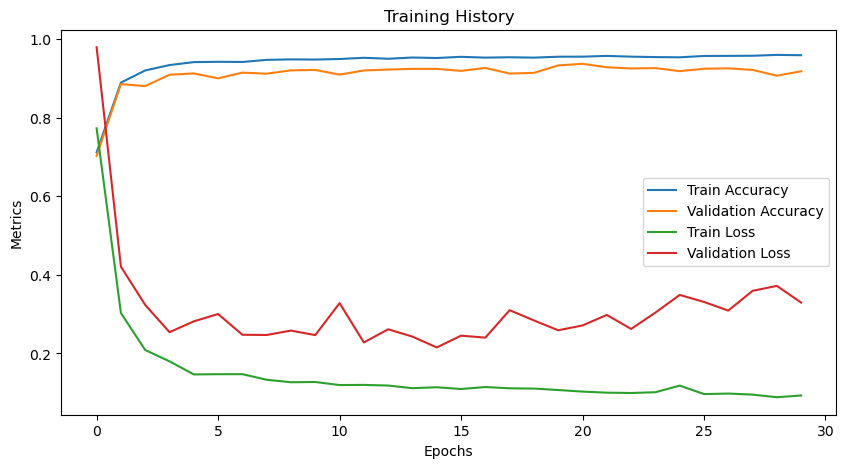

In [10]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.title('Training History')
    plt.show()

plot_training_history(history)

### Evaluate the model

In [11]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, Y_test, batch_size=batch_size)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8748 - loss: 0.2758
Test Accuracy: 92.37%


### Confusion Matrix

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


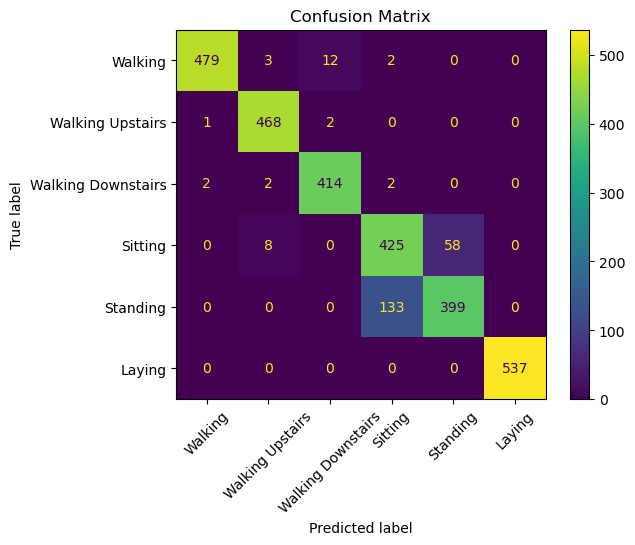

In [13]:
# Confusion Matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
conf_matrix = cm(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(activity_map.values()))
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

### Classification Report

In [14]:
print(cr(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       496
           1       0.97      0.99      0.98       471
           2       0.97      0.99      0.98       420
           3       0.76      0.87      0.81       491
           4       0.87      0.75      0.81       532
           5       1.00      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.92      0.92      2947

